# Seleção de atributos

- Análise dos atributos escolhidos utilizando Random Forests.

In [1]:
import pandas as pd 
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from model_utils import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Análise de correlação

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [3]:
data_df = get_data(COLUMNS, False)

In [4]:
cor = data_df.corr()

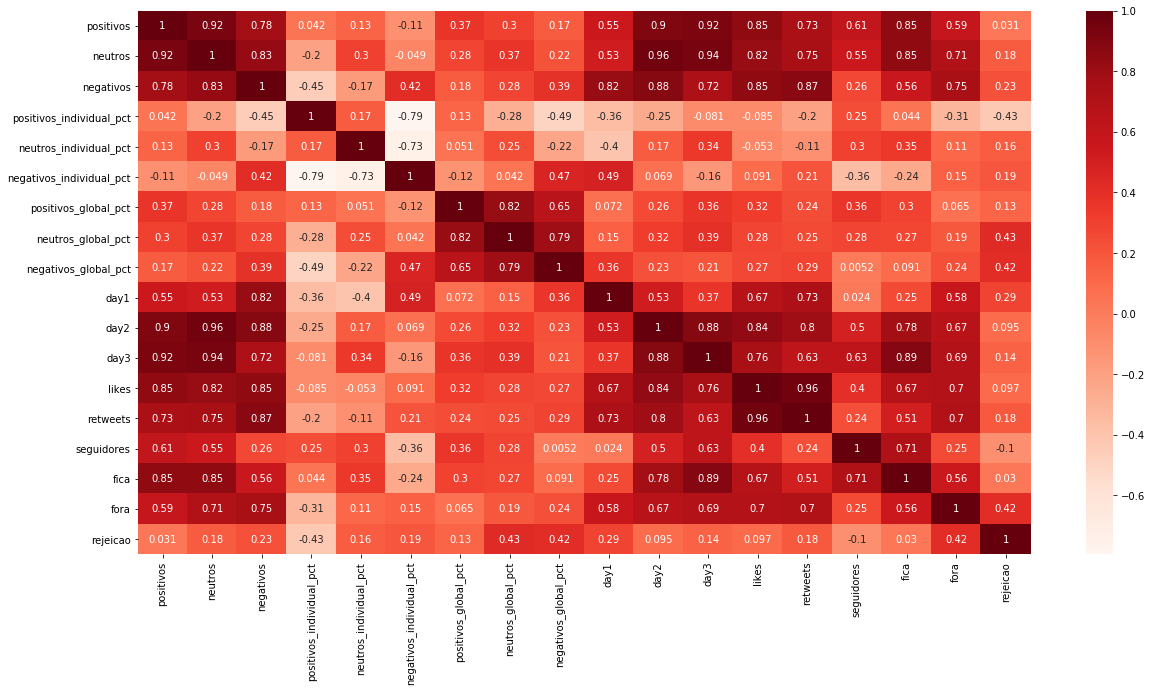

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- Ordenando por correlação

In [6]:
cor_target = abs(cor["rejeicao"])
cor_target.sort_values(ascending=False)

rejeicao                    1.000000
neutros_global_pct          0.431215
positivos_individual_pct    0.428733
negativos_global_pct        0.417141
fora                        0.417003
day1                        0.289279
negativos                   0.227234
negativos_individual_pct    0.194812
retweets                    0.182523
neutros                     0.176117
neutros_individual_pct      0.162825
day3                        0.139718
positivos_global_pct        0.126399
seguidores                  0.104207
likes                       0.096679
day2                        0.094896
positivos                   0.031029
fica                        0.030074
Name: rejeicao, dtype: float64

- Filtrando por correlação superior a 0.5

In [7]:
relevant_features = cor_target[cor_target > 0.5]

In [8]:
relevant_features

rejeicao    1.0
Name: rejeicao, dtype: float64

- Correlação ao atributo alvo (rejeicao) de todos os atributos

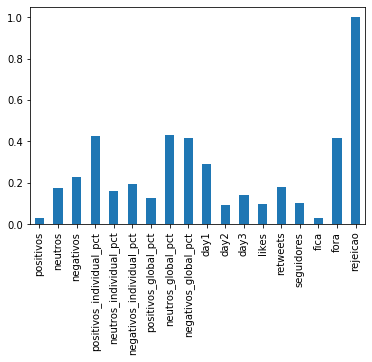

In [9]:
cor_target.plot.bar()

# Eliminando atributos correlacionados

In [10]:
correlated_features = set()
correlation_matrix = data_df.drop("rejeicao", axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
len(correlated_features)

9

In [12]:
correlated_features

{'day1',
 'day2',
 'day3',
 'fica',
 'likes',
 'negativos',
 'neutros',
 'neutros_global_pct',
 'retweets'}

# Análise de importancia de atributos

In [13]:
cols = data_df.columns

In [15]:
summary_df = pd.DataFrame({"importancia_acumulada": [0]*len(cols)}, index=cols, columns=["importancia_acumulada"])
summary_df.drop(index=DEFAULT_COLUMNS, inplace=True)

In [16]:
x_train, y_train = data_df.drop(columns=DEFAULT_COLUMNS, axis=1).to_numpy(), data_df.drop(columns=data_df.columns[:-1], axis=1).to_numpy()
regressor = SelectFromModel(RandomForestRegressor(n_estimators=100))
_ = regressor.fit(x_train, y_train)

In [17]:
features = regressor.get_support()
columns = data_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
indexes = columns[features]
features_importance = regressor.estimator_.feature_importances_

summary_df["importancia_acumulada"] = features_importance

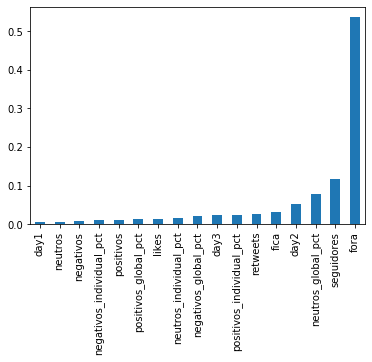

In [18]:
summary_df.sort_values(by="importancia_acumulada")["importancia_acumulada"].plot.bar()

In [19]:
summary_df.sort_values(by="importancia_acumulada", ascending=False)

,importancia_acumulada
fora,0.536290
seguidores,0.116734
neutros_global_pct,0.078392
day2,0.052284
fica,0.032717
retweets,0.026867
positivos_individual_pct,0.024665
day3,0.024297
negativos_global_pct,0.021772
neutros_individual_pct,0.016418


# Combinando os resultados

In [20]:
summary_df["corr"] = [cor_target[index] for index in summary_df.index]

In [21]:
summary_df.sort_values(by=["importancia_acumulada", "corr"], ascending=False)

,importancia_acumulada,corr
fora,0.536290,0.417003
seguidores,0.116734,0.104207
neutros_global_pct,0.078392,0.431215
day2,0.052284,0.094896
fica,0.032717,0.030074
retweets,0.026867,0.182523
positivos_individual_pct,0.024665,0.428733
day3,0.024297,0.139718
negativos_global_pct,0.021772,0.417141
neutros_individual_pct,0.016418,0.162825


# RFE


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
IGNORE_MODELS = ["knn", "svr", "ensamble2", "ensamble3"]

In [23]:
def get_minimum_features(regressor_model, x: np.array, y: np.array) -> Tuple[int, float]:
  
    best_score = 0
    n_features = 0           

    for n in range(1, len(columns)):
        rfe = RFE(regressor_model, n)
        X_train_rfe = rfe.fit_transform(x, y)
        preds = cross_val_predict(regressor_model, X_train_rfe, y, cv=10, n_jobs=5)
        score = r2_score(y, preds)

        # Quanto menor o mse melhor. Se utilizar r2, é necessário alterar aqui
        if(score > best_score):
            best_score = score
            n_features = n

    return n_features, best_score


In [24]:
def run_rfe() -> Dict[str, List[str]]:
    model_features = {}

    paredoes = len(os.listdir(PATH_TO_DATA))


    for model in MODELS.keys():
        if model in IGNORE_MODELS: continue

        params = PARAMETERS_ALL_ATRIBUTES[model]
        regressor_model = MODELS[model]
        norm = NORMALIZE[model]

        data_df = get_data(COLUMNS, normalize=norm)

        columns = data_df.drop(columns=["paredao", "nome", "rejeicao"]).columns
        x, y = data_df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), data_df.drop(columns=data_df.columns[:-1], axis=1).to_numpy()

        reg = regressor_model(**params)
        selector = RFECV(reg, scoring="r2", cv=10)
        selector.fit(x, y)
        model_features[model]  = columns[selector.support_].to_list()

        print(f"-- model: {model}, features: {selector.n_features_}, best score: {selector.grid_scores_[selector.grid_scores_.argmax()]}")
    
    return model_features

In [25]:
selected_features = run_rfe()

-- model: linear_regression, features: 1, best score: 0.025554167714714325
-- model: ada_boost, features: 13, best score: 0.4840830983243853
-- model: random_forest, features: 4, best score: 0.5756020272060247
-- model: lasso, features: 16, best score: 0.040954738517849185
-- model: ridge, features: 11, best score: 0.2585179783037983
-- model: elastic_net, features: 6, best score: 0.07108851414749492
-- model: sgd, features: 14, best score: 0.16648405562567317


In [26]:
for model in IGNORE_MODELS:
    selected_features[model] = selected_features["random_forest"]

In [27]:
with open("selected_features.json", "w") as f:
    json.dump(selected_features, f, indent=2)